# Rowgometer Project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sm
import sympy.physics.mechanics as me
from pydy.system import System
from pydy.viz import Cylinder, Plane, VisualizationFrame, Scene
import pythreejs as pjs
from scipy.interpolate import interp1d
me.init_vprinting()

# Define Variables

First define the system constants:

- $m_b$: Mass of the boat.
- $m_{fw}$: Mass of the flywheel
- $r_{diff}$: radius of the input gear to the differential
- $r_{fw}$: radius of the input gear to the flywheel 
- $r_{ts}$: radius of the input gear to the torsional spring
- $r_{da}$: radius of the input gear to the drive axle
- $r_w$: radius of the wheel of the rowing machine
- $J_{fw}$: first moment of inertia of the flywheel
- $K_{ts}$: Stiffness of the torsional spring

In [2]:
mr, mb, mfw, l1, l2, l3, rdiff, rfw, rts, rda, rw, Jfw, Rfw, Rts, Kts= sm.symbols('m_r,m_b,m_fw,l_1,l_2,l_3,r_diff,r_fw, r_ts, r_da, r_w, J_fw, R_fw,R_ts, K_ts')

There are two time varying generalized coordinates:

- $q_1$: The displacement of the rowing machine
- $q_4$: The angular displacement of the input differential

The two generalized speeds will then be defined in the trivial case:

- $u_1(t)=\dot{q_1}$: The velocity of the rowing machine
- $u_4(t) = \dot{q_4}$: The angular velocity of the input differential

In [3]:
q1 = me.dynamicsymbols('q1')
q4 = me.dynamicsymbols('q4') 
u1 =  me.dynamicsymbols('u1')
u4 = me.dynamicsymbols('u4')
FF, FH = me.dynamicsymbols('FF, FH')
t = me.dynamicsymbols._t

The kinematical differential equations:

$$0 = u_1 - \dot{q_1}\\
0 = u_4 - \dot{q_4}$$

In [4]:
kin_diff = (u1 - q1.diff(), u4 - q4.diff())
kin_diff

#Trivial Equations for Substitution
gs1 = sm.Eq(u1, q1.diff())
gs4 = sm.Eq(u4, q4.diff())
[gs1, gs4]

qdots = sm.solve([gs1, gs4], q1.diff(), q4.diff(), dict =True)
qdots

# Define Orientations

There are two reference frames. These are defined as such:

In [5]:
N = me.ReferenceFrame('N') #Inertial Reference Frame
B = me.ReferenceFrame('B') #Attached to Differential Input
C = me.ReferenceFrame('C') #Attached to Flywheel
D = me.ReferenceFrame('D') #Attched to Torsional Spring

# Holonomic Constraints

### Differential Constitutive Law
$$2\theta_{in} = 2 q_4= \theta_{out,R} + \theta_{out,L}$$

### No Slip Condition
$$\theta_{Drive Axle} = \frac{q_1}{R_w}$$

### Gear Relationships
$$\theta_{Drive Axle} = \frac{r_{diff}}{r_{da}} \theta_{out,L}\\
\theta_{Torisonal Spring} = \frac{r_{diff}}{r_{ts}} \theta_{out,R}\\
\theta_{Fly Wheel} = \frac{r_{diff}}{r_{fw}} \theta_{out,R}$$

## Orientation Relationships
$$\theta_{fw} = \frac{r_{diff}}{r_{fw}} (2 q_4 + \frac{r_{da}}{r_{diff} r_w} q_1)\\
\theta_{ts} = -\frac{r_{da}}{r_{ts} r_w} q_1$$

In [6]:
qfw = (rdiff/rfw)*(2*q4+(rda/(rdiff*rw))*q1) #displacement of flywheel
qts = (-rda/(rts*rw))*q1 #displacement of torsional Spring

B.orient(N, 'Axis', (q4, N.z))
C.orient(N, 'Axis', (qfw, N.z))
D.orient(N, 'Axis', (qts, N.z))

# Define Positions

Four points are necessary to define the problem:

- $N_o$: The fixed point in inertial RF
- $B_o$: The point of the center of the differential drive
- $C_o$: The point of the center of the flywheel
- $D_o$: The point of the center of the torsional spring
- $P_B$: The point attached to the boat

In [7]:
No = me.Point('No')
Bo = me.Point('Bo')
Co = me.Point('Co')
Do = me.Point('Do')
PB = me.Point('PB')

In [8]:
Bo.set_pos(No, 0)
Co.set_pos(No, 0)
Do.set_pos(No, 0)

# Specify the Velocities

In [9]:
qfwdot = (qfw.diff(t)).subs(qdots[0])
qtsdot = (qts.diff(t)).subs(qdots[0])

B.set_ang_vel(N, u4*N.z)
C.set_ang_vel(N, qfwdot*N.z)
D.set_ang_vel(N, qtsdot*N.z)

In [10]:
No.set_vel(N,0)
Bo.set_vel(N,0)
Co.set_vel(N,0)
Do.set_vel(N,0)

PB.set_vel(N, u1*N.x)

 # Inertia

In [11]:
#flywheel
Ifw = (me.inertia(C, 0 ,0, Jfw),Bo)

# Contributing Force and Torque Vectors

In [12]:
THd = (B,rdiff*FH*N.z) #applied at B
FFPB = (PB,FF*N.x) #applied at PB
Tfw = (C,-qfwdot*Rfw*C.z) #applied at C
Tts = (D,-qts*Kts*D.z) #applied at D

# EOM

In [13]:
kane = me.KanesMethod(N, q_ind = (q1, q4), u_ind = (u1, u4), kd_eqs = kin_diff)

In [14]:
flywheel = me.RigidBody('flywheel', Co, C, mfw, Ifw)
boat = me.Particle('boat', PB, mb)

In [15]:
bodies = (flywheel, boat)
loads = (THd, FFPB, Tfw, Tts)

In [16]:
fr, frstr = kane.kanes_equations(bodies,loads)

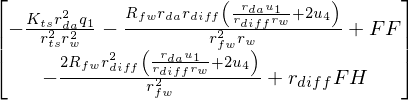

In [17]:
sm.trigsimp(fr)

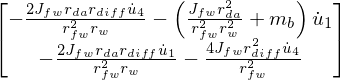

In [18]:
sm.trigsimp(frstr)

# Create Force Vector

In [19]:
#These points are taken from a report on Biorow.com, reference in pdf 

Force_time = [0,0.12,0.69,0.82,0.86,0.88,0.92,0.95,1.08,1.19,1.35,1.38,1.405,1.43,1.46,1.49,1.55,1.65,1.75,2.0]
Force_hands = [100,100,170,280,420,560,700,840,920,980,840,700,560,420,280,170,125,100,100,100]

Force_time2 = [0,0.2,0.34,0.44,0.49,0.55,0.58,0.71,0.82,0.9,1.05,1.1,1.18,1.2,1.21,1.23,1.24,1.25,1.26,1.27,1.28,1.29,1.30,1.37,1.40, 1.48,1.58,1.65, 1.75, 2]
Force_feet = [0,125,250,375,500,625,750,875,1000,1125,1250,1325,1250,1125,1000,875,750,625,500,375,250,125,0,-125,-25,-100,-25,0, 10,0]


In [20]:
#1-D interpolation

FHint = interp1d(Force_time, Force_hands) 
FFint = interp1d(Force_time2, Force_feet)

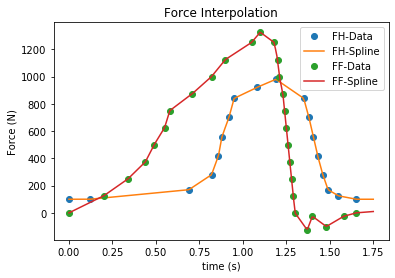

In [21]:
#Plot Interpolated Force Functions

xnew = np.linspace(0,1.75,200)
ynew = FHint(xnew)   # use interpolation function returned by `interp1d`
ynew2 = FFint(xnew)
plt.plot(Force_time[:-2], Force_hands[:-2], 'o', xnew, ynew, '-', Force_time2[:-2], Force_feet[:-2], 'o', xnew, ynew2, '-')
plt.legend(['FH-Data', 'FH-Spline', 'FF-Data', 'FF-Spline'])
plt.title('Force Interpolation')
plt.xlabel('time (s)')
plt.ylabel('Force (N)')
plt.show()

# Simulation

In [22]:
sys = System(kane)

In [23]:
def calc_FF(x,t):
    if t<1.75:
        inter = FFint(t)
    else:
        inter = 0
    return(inter)

def calc_FH(x,t):
    if t< 1.75:
        inter = FHint(t)
    else:
        inter = 0
    return(inter)

sys.specifieds = {FF:calc_FF, FH:calc_FH}

In [30]:
sys.constants = {
    mb: 120, #kg
    rdiff:1, #m
    rfw: 1, #m
    rts: 1, #m
    rda: 1, #m
    rw: 1, #m
    Jfw: 1, #kg-m^2
    Rfw: 0.5, # N/m/s
    Kts: 2000 #N/m
}

In [31]:
sys.times = np.linspace(0,2.5,200)

In [32]:
sys.initial_conditions={q1: 0, q4: 0, u1: 0, u4: 0}

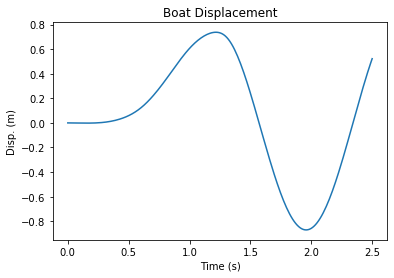

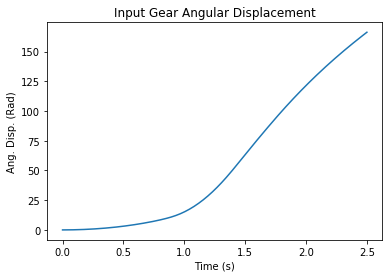

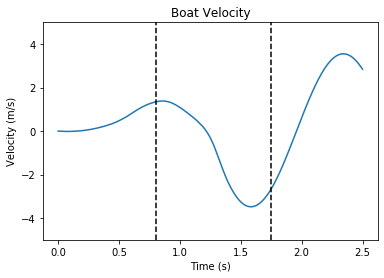

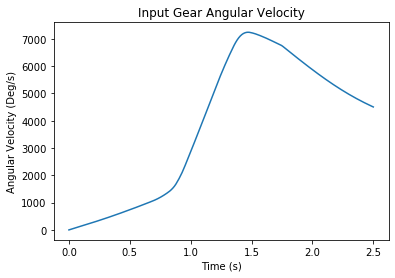

In [35]:
x = sys.integrate()
def plot():
    plt.figure()
    plt.plot(sys.times, x[:,0])
    plt.title('Boat Displacement')
    plt.xlabel('Time (s)')
    plt.ylabel('Disp. (m)')
plot()

def plot():
    plt.figure()
    plt.plot(sys.times, (x[:,1]))
    plt.title('Input Gear Angular Displacement')
    plt.xlabel('Time (s)')
    plt.ylabel('Ang. Disp. (Rad)')
plot()

def plot():
    plt.figure()
    plt.plot(sys.times, (x[:,2]))
    plt.title('Boat Velocity')
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity (m/s)')
    plt.ylim(-5,5)
    plt.axvline(x=0.8,color ='k',linestyle='--')
    plt.axvline(x=1.75,color ='k',linestyle='--')
plot()

def plot():
    plt.figure()
    plt.plot(sys.times, np.rad2deg(x[:,3]))
    plt.title('Input Gear Angular Velocity')
    plt.xlabel('Time (s)')
    plt.ylabel('Angular Velocity (Deg/s)')
plot()


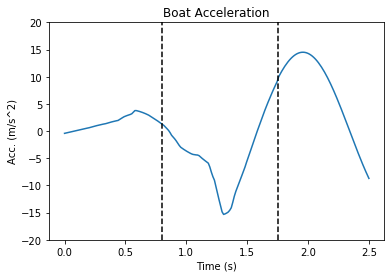

In [34]:
#Plot Acceleration of the boat

xdots = np.zeros((len(sys.times),4))

for i in range(0,len(sys.times)):
    xdots[i] = sys.evaluate_ode_function(x[i, :], sys.times[i], sys.specifieds, sys.constants)

xdots

def plot():
    plt.figure()
    plt.plot(sys.times, xdots[:,2])
    plt.title('Boat Acceleration')
    #plt.plot(sys.times, (x[:,2]))
    plt.xlabel('Time (s)')
    plt.ylabel('Acc. (m/s^2)')
    plt.ylim(-20,20)
    plt.axvline(x=0.8,color ='k',linestyle='--')
    plt.axvline(x=1.75,color ='k',linestyle='--')
    #plt.legend(['Acceleration', 'Velocity','Catch/Finish'])
plot()